<a href="https://colab.research.google.com/github/angkmfirefoxygal/AIHub_korean_txt/blob/main/male2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [8]:
%cd dialouges/

/content/drive/MyDrive/dialouges


In [16]:
df = pd.read_csv("/content/drive/MyDrive/dialouges/male1.csv", encoding= "utf-8")

In [17]:
# 'utterance' 열에서 텍스트 추출
text = ' '.join(df['utterance'].dropna().astype(str))

In [18]:
print(text)

In [19]:
# 텍스트 전처리: 불필요한 문자 제거, 소문자 변환 등
def preprocess_text(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  # 특수문자 제거
    return text

In [20]:
# 필요한 라이브러리 설치
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# KcELECTRA 모델과 토크나이저 로드
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 감정 분석 파이프라인 생성
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 분석할 텍스트
# text = """이 프로젝트는 정말 흥미로워요. 하지만, 아직 개선할 부분이 많아 보이네요.
# 오늘은 기분이 좋아요. 그런데 내일은 걱정이 되네요."""

# 텍스트를 문장 단위로 분리
sentences = text.split('. ')
sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # 공백 제거 및 빈 문장 제외

# 각 문장에 대해 감정 분석 실행
results = []
for sentence in sentences:
    try:
        result = sentiment_analyzer(sentence)
        results.append({"sentence": sentence, "label": result[0]['label'], "score": result[0]['score']})
    except Exception as e:
        print(f"에러 발생: {e}")

# 결과 출력
for result in results:
    print(f"문장: {result['sentence']}")
    print(f"감정: {result['label']}, 점수: {result['score']:.2f}")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [25]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


In [28]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import evaluate

# 평가 지표 로드
metric = evaluate.load("accuracy")

# 데이터 준비
data = {'text': ["오늘 기분이 좋네요.", "너무 힘들고 지치네요."], 'label': [0, 1]}  # 0=positive, 1=negative
dataset = Dataset.from_dict(data)

# 토크나이저 및 모델 로드
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 데이터 토큰화
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 학습 설정 (wandb 비활성화)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"  # wandb 비활성화
)

# Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics,
)

# Fine-Tuning 수행
trainer.train()

# 학습된 모델 저장
model.save_pretrained("./kc-electra-finetuned")
tokenizer.save_pretrained("./kc-electra-finetuned")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.683199,0.500000
2,No log,0.662461,0.500000
3,No log,0.653015,0.500000


('./kc-electra-finetuned/tokenizer_config.json',
 './kc-electra-finetuned/special_tokens_map.json',
 './kc-electra-finetuned/tokenizer.json')

In [30]:
# 필요한 라이브러리 설치
!pip install transformers pandas

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 미리 Fine-Tuned된 모델 로드
model_name = "beomi/KcELECTRA-base"  # 또는 "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 감정 분석 파이프라인 생성
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 데이터 불러오기
csv_test2 = pd.read_csv('/content/drive/MyDrive/dialouges/male2.csv')

# 'utterance' 열에서 텍스트 추출
utterances = csv_test2['utterance'].dropna().astype(str).tolist()

# 문장 단위로 분석
results = []
for utterance in utterances:
    # 문장 단위로 분리
    sentences = utterance.split('. ')  # '.' 기준으로 문장 나누기
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # 공백 제거 및 빈 문장 제외

    # 각 문장에 대해 감정 분석 실행
    for sentence in sentences:
        try:
            result = sentiment_analyzer(sentence)
            results.append({
                "utterance": utterance,  # 전체 문장
                "sentence": sentence,    # 개별 문장
                "label": result[0]['label'],
                "score": result[0]['score']
            })
        except Exception as e:
            print(f"에러 발생: {e}")

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 결과 확인
print(results_df.head())

# 결과를 CSV 파일로 저장
results_df.to_csv('/content/drive/MyDrive/dialouges/male1_analysis_results.csv', index=False)

# 개별 결과 출력
for result in results:
    print(f"문장: {result['sentence']}")
    print(f"감정: {result['label']}, 점수: {result['score']:.2f}")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                        utterance                  sentence    label     score
0   안녕하세요. 저는 30대 남자이고 선박 정비원입니다.                     안녕하세요  LABEL_0  0.527505
1   안녕하세요. 저는 30대 남자이고 선박 정비원입니다.    저는 30대 남자이고 선박 정비원입니다.  LABEL_0  0.507794
2  그렇군요. 저는 직업과 다르게 사회교육과를 전공했어요.                      그렇군요  LABEL_0  0.528467
3  그렇군요. 저는 직업과 다르게 사회교육과를 전공했어요.  저는 직업과 다르게 사회교육과를 전공했어요.  LABEL_0  0.507389
4              그러세요? 왜 가끔 슬프신 거죠?        그러세요? 왜 가끔 슬프신 거죠?  LABEL_0  0.518198
문장: 안녕하세요
감정: LABEL_0, 점수: 0.53
문장: 저는 30대 남자이고 선박 정비원입니다.
감정: LABEL_0, 점수: 0.51
문장: 그렇군요
감정: LABEL_0, 점수: 0.53
문장: 저는 직업과 다르게 사회교육과를 전공했어요.
감정: LABEL_0, 점수: 0.51
문장: 그러세요? 왜 가끔 슬프신 거죠?
감정: LABEL_0, 점수: 0.52
문장: 그렇구나.
감정: LABEL_0, 점수: 0.54
문장: 저는 걷기를 가끔 해요
감정: LABEL_0, 점수: 0.51
문장: ㅋㅋ 님은요.
감정: LABEL_0, 점수: 0.52
문장: 그렇구나~ ㅋㅋ 좋아하는 음식은 있으세요?
감정: LABEL_0, 점수: 0.52
문장: 네
감정: LABEL_0, 점수: 0.54
문장: 치킨 사면 아들과 딸이랑 같이 먹어요.
감정: LABEL_0, 점수: 0.51
문장: 네
감정: LABEL_0, 점수: 0.54
문장: 좀 일찍하긴 했죠
감정: LABEL_0, 점수: 0.52
문장: 님은 미혼이세요?
감정: LABEL

In [31]:
# 감정별 문장 수 계산
from collections import Counter

labels = [result['label'] for result in results]  # 'results'는 분석 결과 리스트
label_counts = Counter(labels)

# 출력
print("감정별 문장 수:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

감정별 문장 수:
LABEL_0: 34
LABEL_1: 2


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

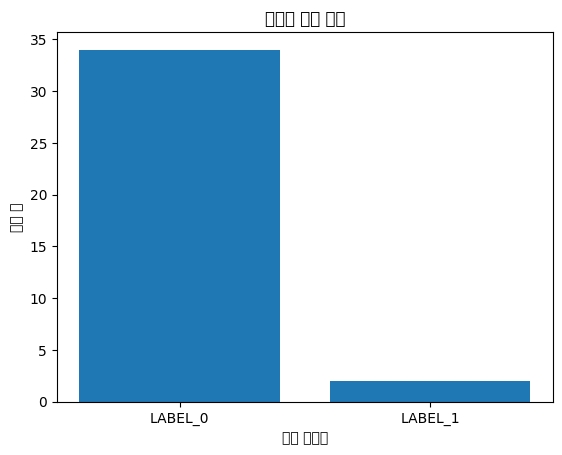

In [32]:
import matplotlib.pyplot as plt

# 감정별 카운트
labels = [result['label'] for result in results]
label_counts = Counter(labels)

# 시각화
plt.bar(label_counts.keys(), label_counts.values())
plt.title("감정별 문장 분포")
plt.xlabel("감정 레이블")
plt.ylabel("문장 수")
plt.show()